In [1]:

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier

## Data Loading & cleaning

In [ ]:
# Model features
cols = [
    'cum_gpa',
    'term_credits_passed',
    'gpa_avg',
    'gpa_zscore_avg',
    'gpa_stddev',
    'gpa_zscore_stddev',
    'units_failed',
    'units_incompleted',
    'units_withdrawn',
    'units_total',
    'units_passed',
    'age',
    'nra',
    'ftic',
    'prev_dual',
    'hs_completed',
    'urm_status',
    
    # Encoded ethnicity indicators
    'ethnicity_2 or more',
    'ethnicity_Asian',
    'ethnicity_Black',
    'ethnicity_Hawaiian',
    'ethnicity_Hispanic',
    'ethnicity_Native Amr',
    'ethnicity_Not Indic',
    'ethnicity_White',

    # Encoded program type
    'program_type_Career Tech',
    'program_type_Transfer',
    'program_type_Unclassified',

    # Encoded sex indicators
    'sex_Female',
    'sex_Male',
    'sex_NotIndicated'
]

df_all = all_school_data

## Performance

In [ ]:
import pandas as pd
import numpy as np
from scipy.stats import entropy, gaussian_kde
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

try:
    import cupy as cp
except ImportError:
    cp = np
    print("Cupy not found; using NumPy (CPU) instead. Performance will be slower.")

def estimate_p_y_knn_gpu(X_train, y_train, X_query, k=30, batch_size=256):
    try:
        X_tr = cp.asarray(X_train, dtype=cp.float32)
        y_tr = cp.asarray(y_train, dtype=cp.float32)
        X_q  = cp.asarray(X_query, dtype=cp.float32)
    except Exception as e:
        print(f"[GPU init error] {e}, falling back to CPU")
        return estimate_p_y_knn_cpu(X_train, y_train, X_query, k, batch_size)

    n_query = X_q.shape[0]
    probs = np.empty(n_query, dtype=float)

    for i in range(0, n_query, batch_size):
        j = min(i + batch_size, n_query)
        chunk = X_q[i:j]
        try:
            diff = X_tr[:, None, :] - chunk[None, :, :]
            d2 = cp.einsum('tbf,tbf->tb', diff, diff)
            idx = cp.argpartition(d2, k, axis=0)[:k, :]
            neigh = cp.take(y_tr, idx, axis=0)
            p_chunk = cp.mean(neigh, axis=0)
            probs[i:j] = cp.asnumpy(p_chunk)
        except Exception as e:
            print(f"[GPU batch error @ {i}:{j}] {e}, falling back to CPU")
            return estimate_p_y_knn_cpu(X_train, y_train, X_query, k, batch_size)

    return probs

def estimate_p_y_knn_cpu(X_train, y_train, X_query, k=30, batch_size=256):
    n_query = X_query.shape[0]
    probs = np.empty(n_query, dtype=float)
    for i in range(0, n_query, batch_size):
        j = min(i + batch_size, n_query)
        chunk = X_query[i:j]
        d2 = np.sum((X_train[:, None, :] - chunk[None, :, :])**2, axis=2)
        idx = np.argpartition(d2, k, axis=0)[:k]
        probs[i:j] = np.mean(y_train[idx], axis=0)
    return probs

def kl_divergence_kde(p, q, eps=1e-10, num_points=1000):
    low, high = min(p.min(), q.min()) - eps, max(p.max(), q.max()) + eps
    grid = np.linspace(low, high, num_points)
    kde_p = gaussian_kde(p, bw_method='scott')
    kde_q = gaussian_kde(q, bw_method='scott')
    p_vals = kde_p(grid) + eps
    q_vals = kde_q(grid) + eps
    return entropy(q_vals, p_vals)

def js_divergence_kde(p, q, eps=1e-10, num_points=1000):
    low, high = min(p.min(), q.min()) - eps, max(p.max(), q.max()) + eps
    grid = np.linspace(low, high, num_points)
    kde_p = gaussian_kde(p, bw_method='scott')
    kde_q = gaussian_kde(q, bw_method='scott')
    p_vals = kde_p(grid) + eps
    q_vals = kde_q(grid) + eps
    p_vals /= p_vals.sum()
    q_vals /= q_vals.sum()
    m_vals = 0.5 * (p_vals + q_vals)
    kl_pm = entropy(p_vals, m_vals)
    kl_qm = entropy(q_vals, m_vals)
    return 0.5 * (kl_pm + kl_qm)

def detect_concept_shift(
    df,
    feature_cols,
    target_col='y',             
    group_col='college_name',
    year_col='year',
    target_year=2021,
    k=30,
    pca_var=0.95,
    min_train=100,
    min_test=50,
    random_state=42
):
    results = []

    for grp in df[group_col].dropna().unique():
        sub = df[df[group_col] == grp]
        for start in range(df[year_col].min(), target_year):
            train_set = sub[sub[year_col].between(start, target_year - 1)]
            test_set  = sub[sub[year_col] == target_year]
            if len(train_set) < min_train or len(test_set) < min_test:
                continue

            X_train = train_set[feature_cols].fillna(0).values
            y_train = train_set[target_col].values
            X_test  = test_set[feature_cols].fillna(0).values
            y_test  = test_set[target_col].values

            scaler = StandardScaler().fit(X_train)
            X_train = scaler.transform(X_train)
            X_test  = scaler.transform(X_test)

            pca = PCA(n_components=pca_var, svd_solver='full')
            Xtr = pca.fit_transform(X_train)
            Xte = pca.transform(X_test)
            eff_k = min(k, len(Xtr) // 2)

            p_train = estimate_p_y_knn_gpu(Xtr, y_train, Xtr, k=eff_k)
            p_test  = estimate_p_y_knn_gpu(Xte, y_test, Xte, k=eff_k)

            kl = kl_divergence_kde(p_train, p_test)
            js = js_divergence_kde(p_train, p_test)

            results.append({
                group_col:       grp,
                'start_year':    start,
                'end_year':      target_year,
                'n_train':       len(train_set),
                'n_test':        len(test_set),
                'pca_dims':      pca.n_components_,
                'k_used':        eff_k,
                'kl_divergence': kl,
                'js_divergence': js
            })

    return pd.DataFrame(results)


In [ ]:
results_knn_js = detect_concept_shift(
    df=Anonymized_college,
    feature_cols=cols,
    target_col='retention',    
    group_col='college_name',   
    year_col='year',            
    target_year=2021            
)
print(results_knn_js.head())


  college_name  start_year  end_year  n_train  n_test  pca_dims  k_used  \
0    Tidewater        2010      2021   184552    9074        21      30   
1    Tidewater        2011      2021   147495    9074        21      30   
2    Tidewater        2012      2021   123114    9074        21      30   
3    Tidewater        2013      2021   103093    9074        21      30   
4    Tidewater        2014      2021    85371    9074        21      30   

   kl_divergence  js_divergence  
0       0.007005       0.001854  
1       0.015204       0.004025  
2       0.017029       0.004509  
3       0.016388       0.004334  
4       0.014454       0.003853  


In [ ]:

from scipy.stats import ks_2samp, chi2_contingency

def cramers_v(conf_matrix):
    chi2 = chi2_contingency(conf_matrix)[0]
    n = conf_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = conf_matrix.shape
    return np.sqrt(phi2 / min(k - 1, r - 1))

def calculate_unified_covariate_shift_looping(Anonymized_college, cols, target_year):
    min_year = Anonymized_college['year'].min()
    train_start_years = list(range(min_year, target_year))
    binary_vars = [col for col in cols if Anonymized_college[col].dropna().nunique() == 2]
    continuous_vars = list(set(cols) - set(binary_vars))

    shift_results = []

    for college in Anonymized_college['college_name'].dropna().unique():
        df_college = Anonymized_college[Anonymized_college['college_name'] == college]
        df_test = df_college[df_college['year'] == target_year]

        if len(df_test) < 30:
            continue

        for start_year in train_start_years:
            train_years = list(range(start_year, target_year))
            df_train = df_college[df_college['year'].isin(train_years)]

            if len(df_train) < 30:
                continue
            try:
                train_cont = df_train[continuous_vars].dropna()
                test_cont = df_test[continuous_vars].dropna()
                all_cont = pd.concat([train_cont, test_cont])

                scaler = StandardScaler()
                all_scaled = scaler.fit_transform(all_cont)
                train_scaled = scaler.transform(train_cont)
                test_scaled = scaler.transform(test_cont)

                pca = PCA(n_components=min(5, all_scaled.shape[1]))
                X_train_pca = pca.fit_transform(train_scaled)
                X_test_pca = pca.transform(test_scaled)

                for i in range(pca.n_components_):
                    x1 = X_train_pca[:, i]
                    x2 = X_test_pca[:, i]
                    shift_results.append({
                        'college': college,
                        'pair': f'{start_year}_to_{target_year}',
                        'feature': f'PCA_{i+1}',
                        'type': 'pca_component',
                        'ks_stat': ks_2samp(x1, x2).statistic
                    })
            except Exception:
                continue

            for feature in binary_vars:
                try:
                    p_train = df_train[feature].mean()
                    p_test = df_test[feature].mean()
                    delta_prop = abs(p_test - p_train)

                    ct = pd.crosstab(
                        df_college[df_college['year'].isin(train_years + [target_year])]['year'],
                        df_college[df_college['year'].isin(train_years + [target_year])][feature]
                    )
                    c_v = cramers_v(ct) if ct.shape == (2, 2) else np.nan

                    shift_results.append({
                        'college': college,
                        'pair': f'{start_year}_to_{target_year}',
                        'feature': feature,
                        'type': 'binary',
                        'delta_prop': delta_prop,
                        'cramers_v': c_v
                    })
                except Exception:
                    continue

    shift_df = pd.DataFrame(shift_results)

    pca_df = shift_df[shift_df['type'] == 'pca_component'].copy()
    pca_df['ks_norm'] = pca_df['ks_stat'] / pca_df['ks_stat'].max()
    pca_df['pca_shift'] = pca_df['ks_norm']

    binary_df = shift_df[shift_df['type'] == 'binary'].copy()
    binary_df['delta_prop_norm'] = binary_df['delta_prop'] / binary_df['delta_prop'].max()
    binary_df['cramers_v_norm'] = binary_df['cramers_v'] / binary_df['cramers_v'].max()
    binary_df['binary_shift'] = binary_df[['delta_prop_norm', 'cramers_v_norm']].mean(axis=1)

    binary_agg = binary_df.groupby(['college', 'pair']).agg(binary_shift_score=('binary_shift', 'mean')).reset_index()
    pca_agg = pca_df.groupby(['college', 'pair']).agg(pca_shift_score=('pca_shift', 'mean')).reset_index()

    combined = pd.merge(binary_agg, pca_agg, on=['college', 'pair'], how='outer')
    combined['unified_shift_score'] = combined[['binary_shift_score', 'pca_shift_score']].mean(axis=1)

    return combined, shift_df


In [ ]:
combined_shift, detailed_shift = calculate_unified_covariate_shift_looping(
    Anonymized_college,
    cols,
    target_year=2021
)


In [ ]:
combined_shift = combined_shift.rename(columns={'college': 'college_name'})

### Concept shift

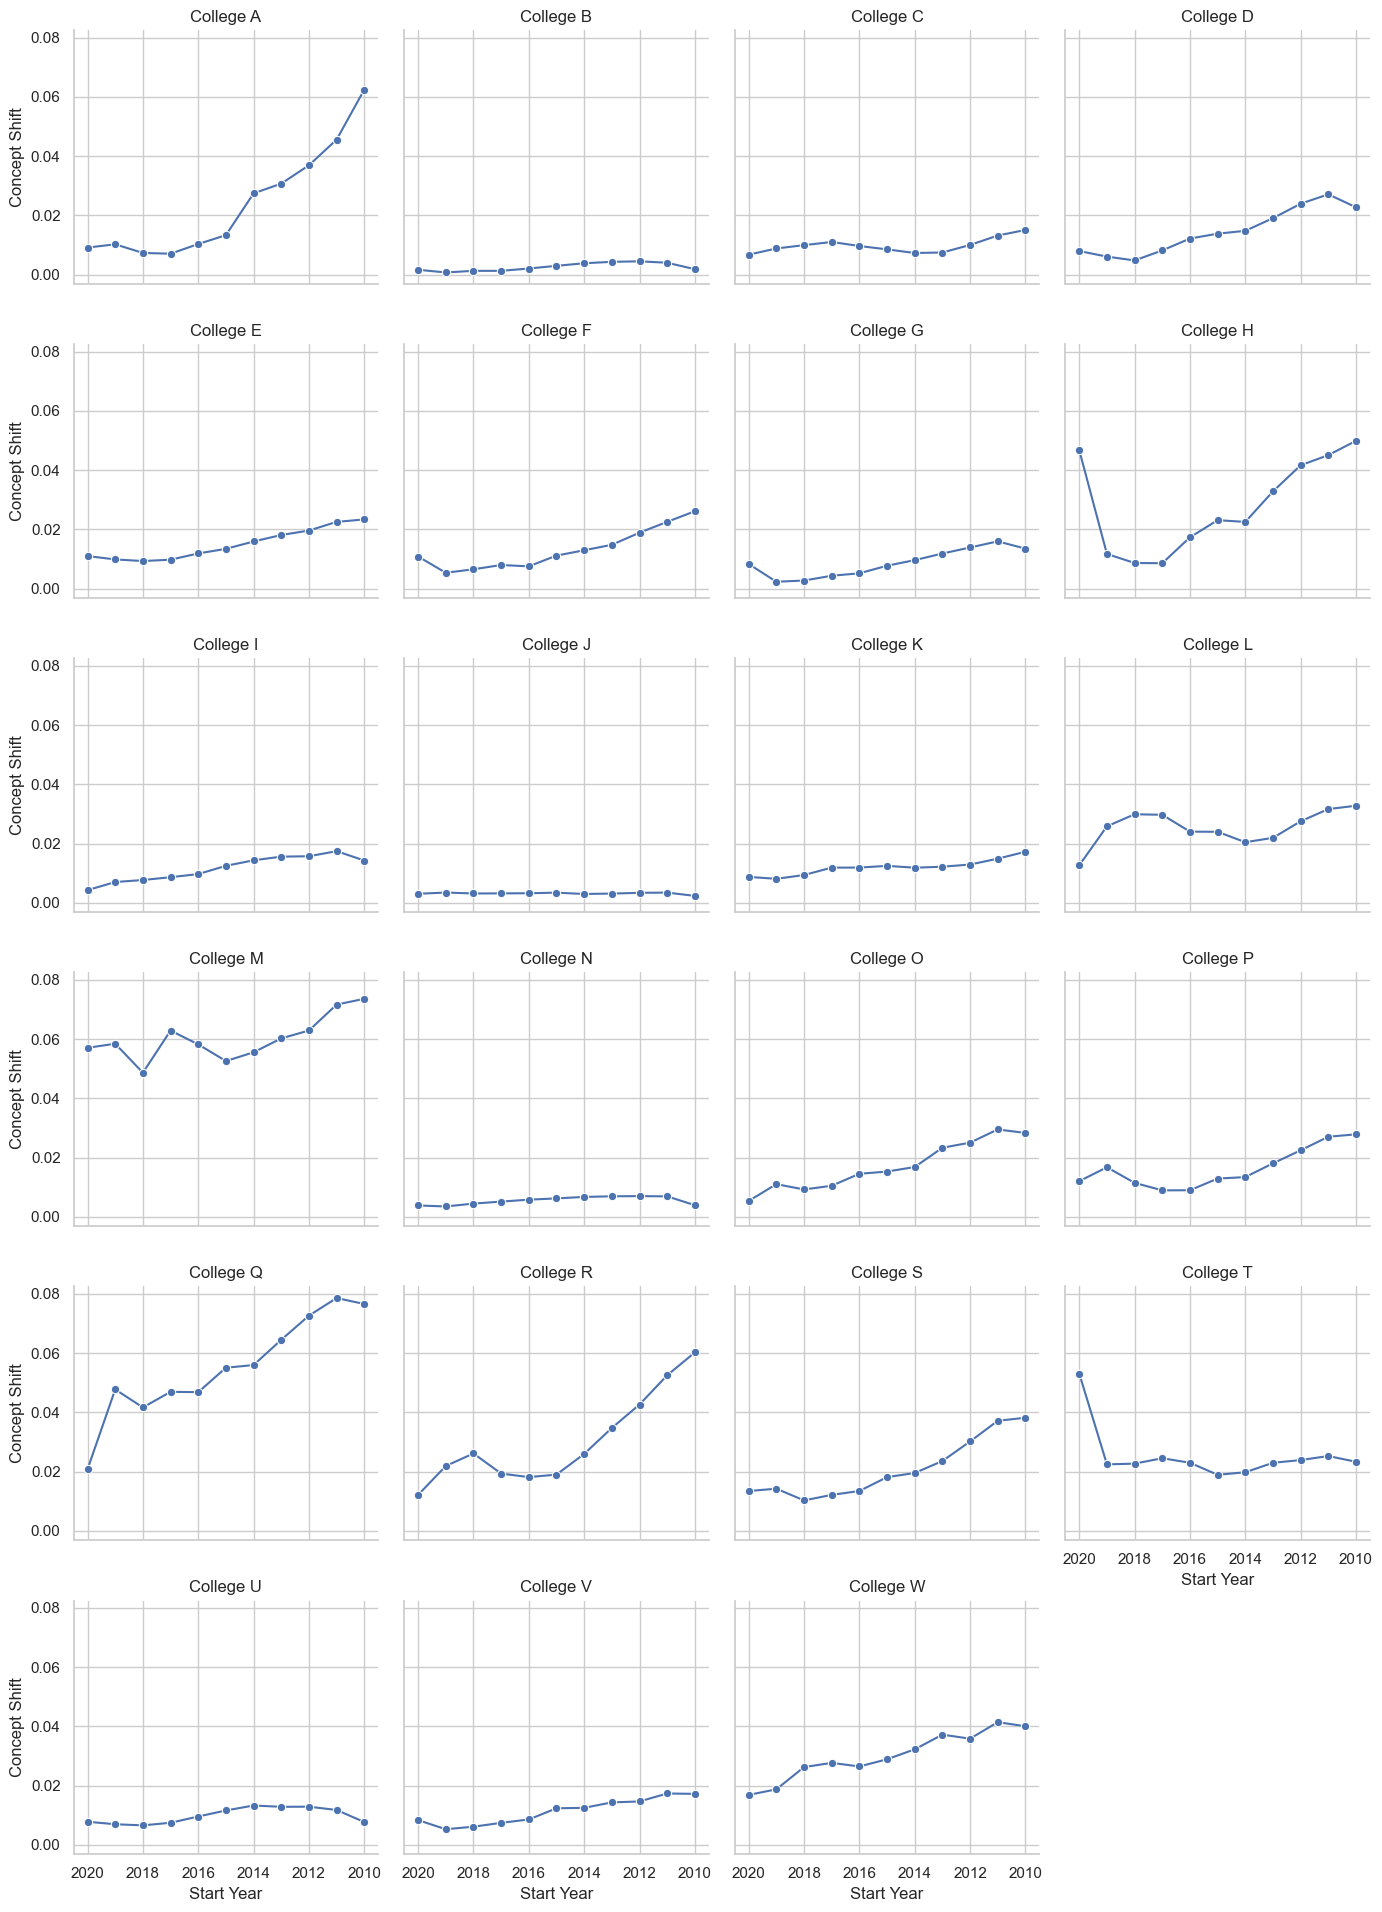

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

manual_mapping = {
    'C1': 'College A',
    'C2': 'College B',
    'C3': 'College C'
}

all_colleges = df_all['college_name'].unique()

remaining = [c for c in all_colleges if c not in manual_mapping]
remaining_mapping = {
    orig: f"College {chr(68+i)}" for i, orig in enumerate(sorted(remaining))
}

anon_names = {**manual_mapping, **remaining_mapping}
df_all['college_anon'] = df_all['college_name'].map(anon_names)

df_all = df_all.sort_values(by=['college_anon', 'start_year'])

sns.set(style="whitegrid")

g = sns.FacetGrid(df_all, col="college_anon", col_wrap=4, height=3.5, sharey=True)
g.map_dataframe(sns.lineplot, x="start_year", y="js_divergence", marker="o")

for ax in g.axes.flatten():
    ax.invert_xaxis()
g.set_axis_labels("Start Year", "Concept Shift")
g.set_titles("{col_name}")

plt.subplots_adjust(top=0.9)
plt.savefig("concept_shift_plot.png", dpi=500)

plt.show()


### Covariate shift

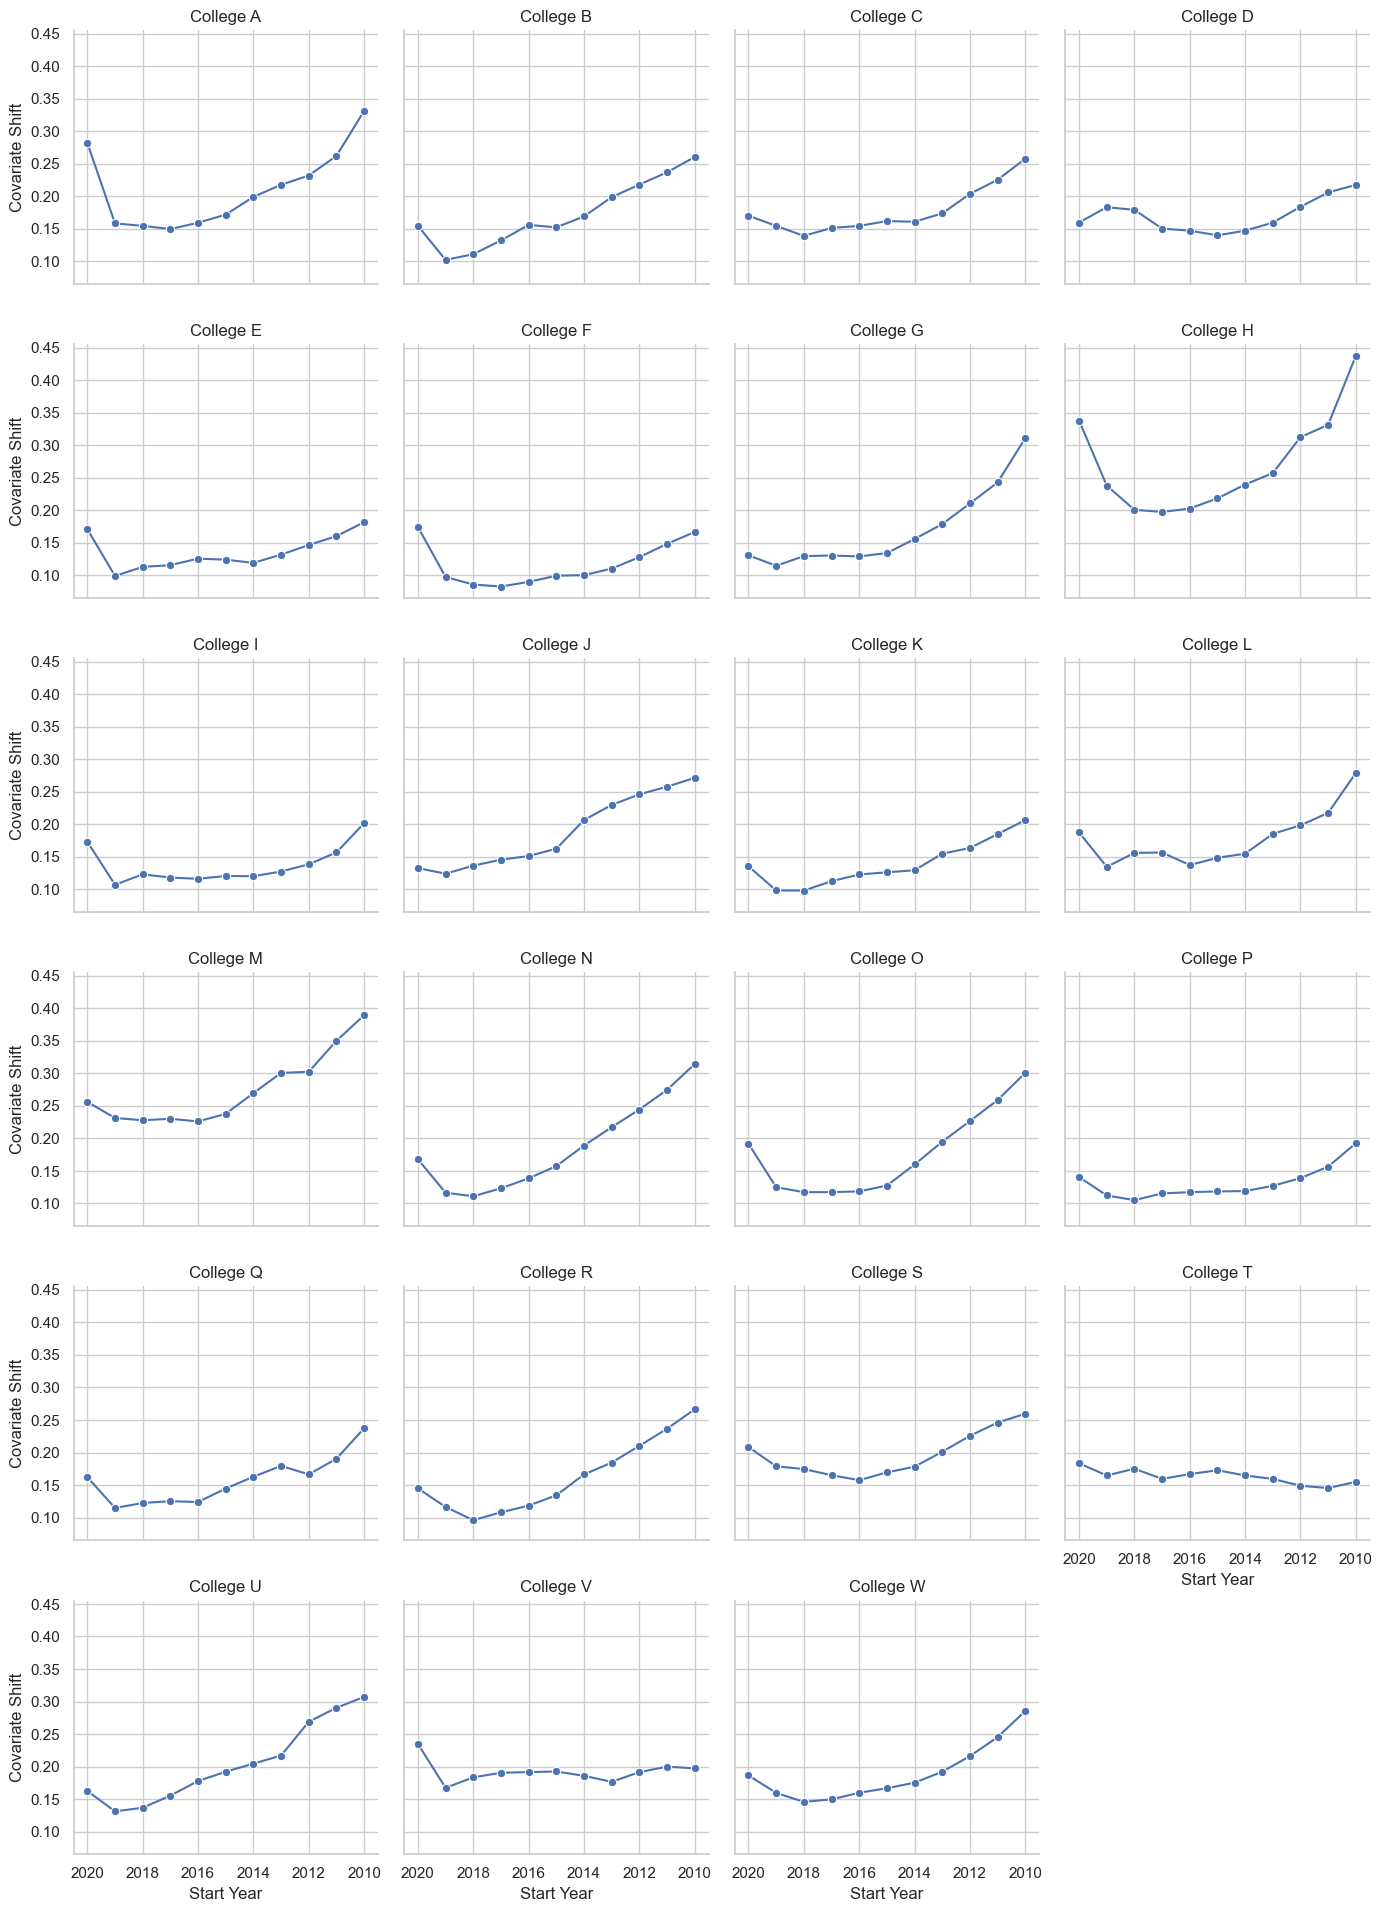

In [ ]:

manual_mapping = {
    'C1': 'College A',
    'C2': 'College B',
    'C3': 'College C'
}

all_colleges = df_all['college_name'].unique()

remaining = [c for c in all_colleges if c not in manual_mapping]
remaining_mapping = {
    orig: f"College {chr(68+i)}" for i, orig in enumerate(sorted(remaining))
}

anon_names = {**manual_mapping, **remaining_mapping}
df_all['college_anon'] = df_all['college_name'].map(anon_names)

df_all = df_all.sort_values(by=['college_anon', 'start_year'])

sns.set(style="whitegrid")

g = sns.FacetGrid(df_all, col="college_anon", col_wrap=4, height=3.5, sharey=True)
g.map_dataframe(sns.lineplot, x="start_year", y="unified_shift_score", marker="o")

for ax in g.axes.flatten():
    ax.invert_xaxis()

g.set_axis_labels("Start Year", "Covariate Shift")
g.set_titles("{col_name}")

plt.subplots_adjust(top=0.9)
plt.savefig("covariate_shift_plot.png", dpi=500)

plt.show()


### AUC

In [ ]:

test_year = 2021
train_end_year = 2020
train_start_year = 2010

results = []

colleges = Anonymized_college['college_name'].dropna().unique()

for college in colleges:
    print(f"📍 Processing: {college}")

    Anonymized_college_college = Anonymized_college[Anonymized_college['college_name'] == college]

    test_df = Anonymized_college_college[Anonymized_college_college['year'] == test_year]
    if len(test_df) < 30:
        print(f"⚠️ Skipped {college} due to insufficient test data in {test_year}.")
        continue

    X_test = test_df[cols].fillna(0)
    y_test = test_df['retention']

    for first_year in range(train_end_year, train_start_year - 1, -1):
        train_years = list(range(first_year, train_end_year + 1))
        train_df = Anonymized_college_college[Anonymized_college_college['year'].isin(train_years)]

        if len(train_df) < 30:
            continue

        X_train = train_df[cols].fillna(0)
        y_train = train_df['retention']

        model = LogisticRegression(max_iter=1000, random_state=42)
        model.fit(X_train, y_train)

        y_test_prob = model.predict_proba(X_test)[:, 1]

        try:
            auc_test = roc_auc_score(y_test, y_test_prob)
        except ValueError:
            print(f"⚠️ Skipped {college}, {first_year}–{train_end_year} due to only one class in y_test.")
            continue

        results.append({
            'college_name': college,
            'train_years': f"{first_year}–{train_end_year}",
            'n_train': len(train_df),
            'auc_test_2019': auc_test
        })

performance = pd.DataFrame(results)
performance = performance.sort_values(by=['college_name', 'train_years'])


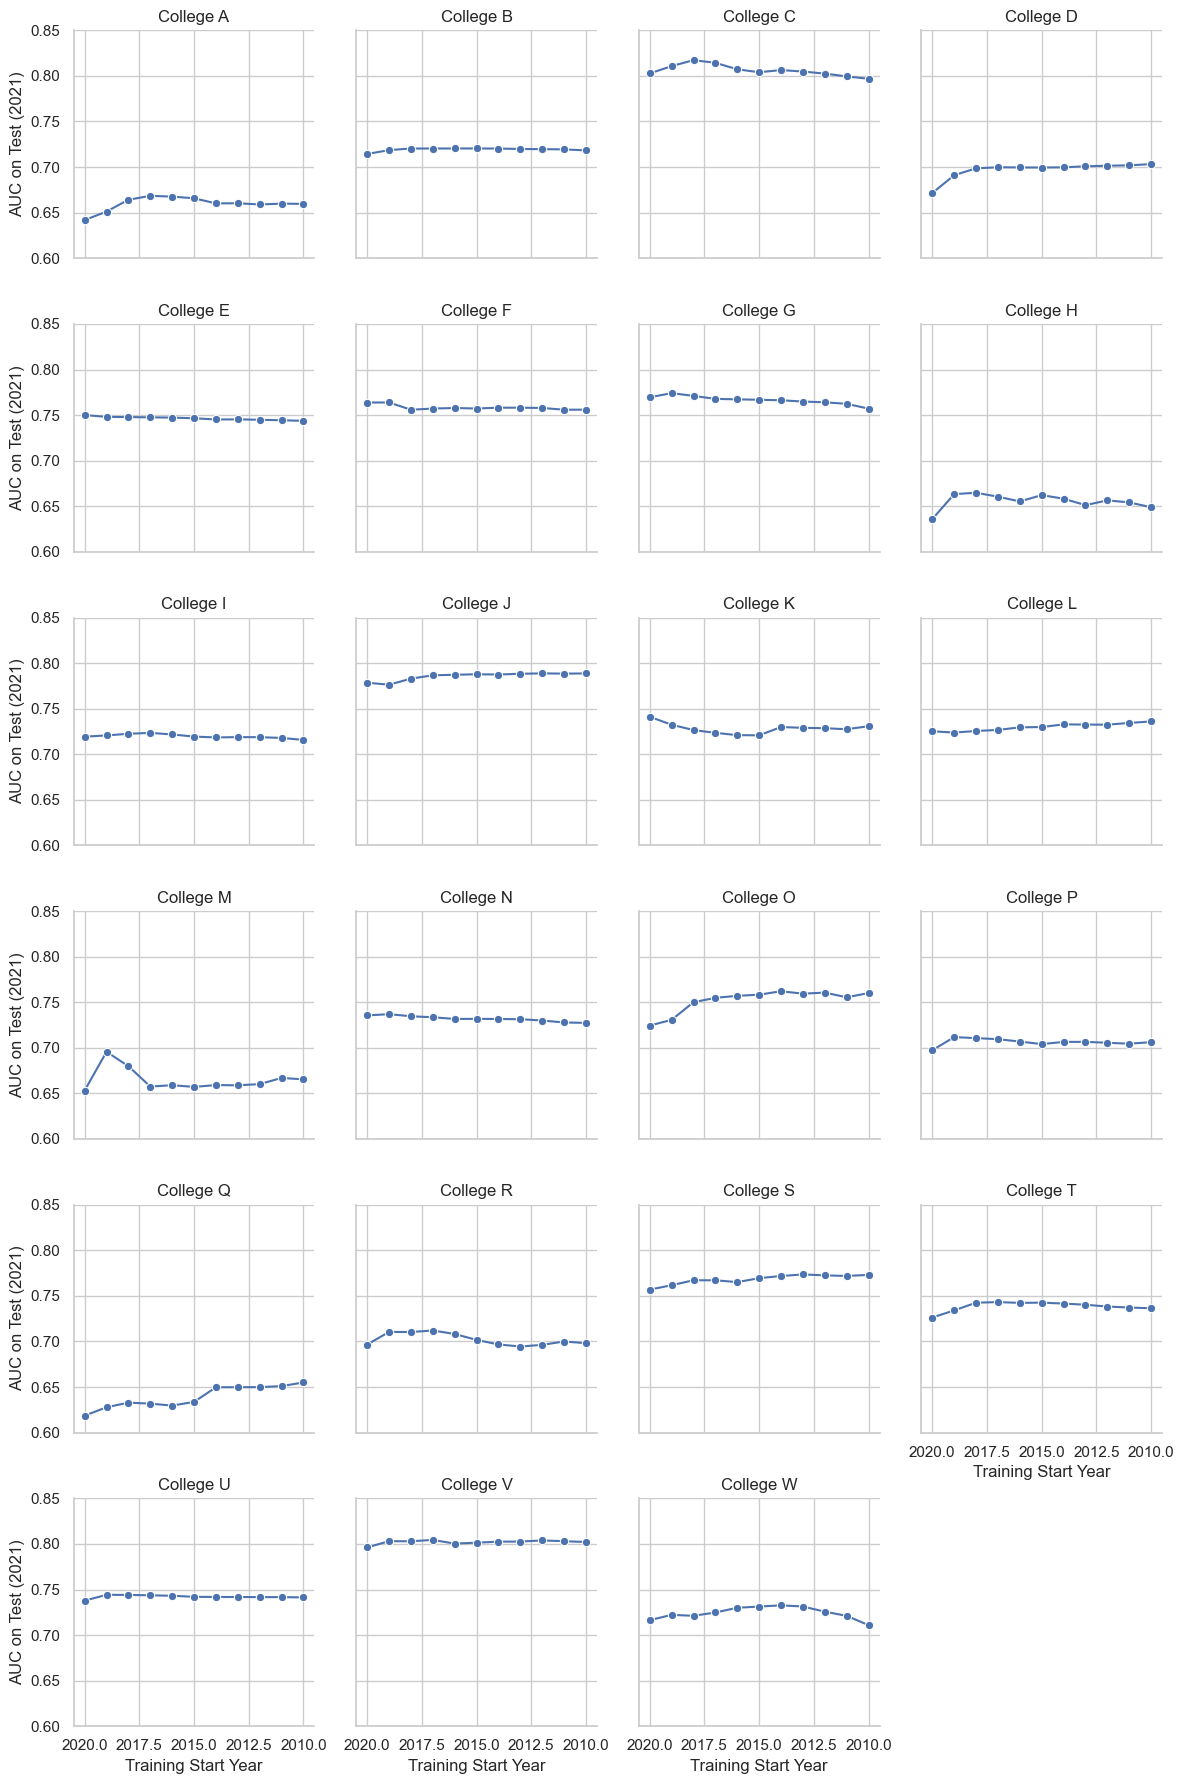

In [ ]:
manual_mapping = {
    'C1': 'College A',
    'C2': 'College B',
    'C3': 'College C'
}

all_colleges = performance['college_name'].unique()
remaining = [c for c in all_colleges if c not in manual_mapping]
remaining_mapping = {
    orig: f"College {chr(68+i)}" for i, orig in enumerate(sorted(remaining))
}
anon_names = {**manual_mapping, **remaining_mapping}
performance['college_anon'] = performance['college_name'].map(anon_names)

performance['train_start'] = performance['train_years'].apply(lambda x: int(x.split('–')[0]))
performance = performance.sort_values(by=['college_anon', 'train_start'])

sns.set(style="whitegrid")
g = sns.FacetGrid(performance, col="college_anon", col_wrap=4, height=3, sharey=True)
g.map_dataframe(sns.lineplot, x='train_start', y='auc_test_2019', marker='o')

for ax in g.axes.flat:
    ax.invert_xaxis()


g.set_axis_labels("Training Start Year", "AUC on Test (2021)")
g.set_titles("{col_name}")
g.set(ylim=(0.6, 0.85)) 

plt.tight_layout()
plt.savefig("auc_test_plot.png", dpi=500)
plt.show()


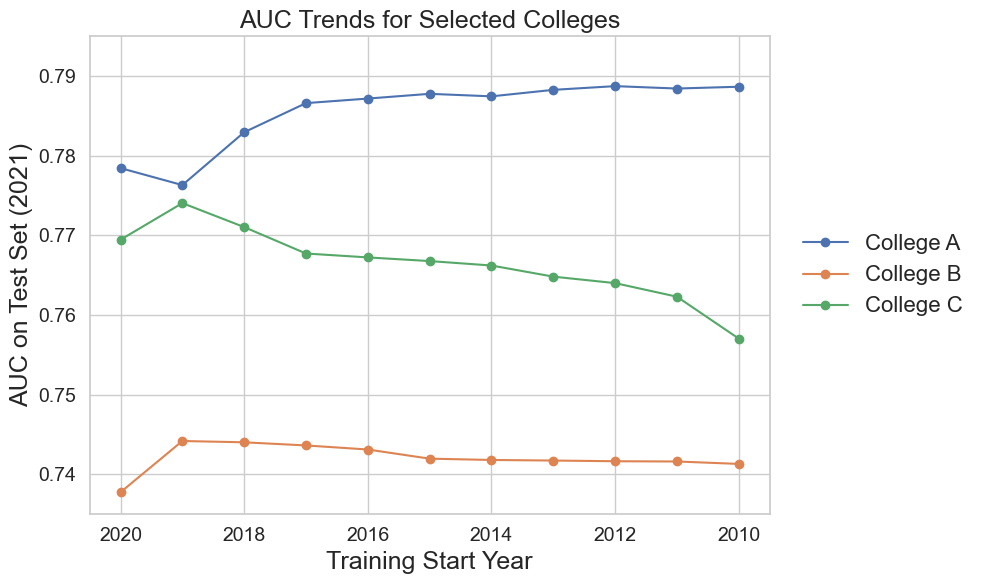

In [ ]:

selected_colleges = ['C1', 'C2', 'C3']
deid_map = {
    'C1': 'College A',
    'C2': 'College B',
    'C3': 'College C'
}

df_plot = performance[performance['college_name'].isin(selected_colleges)].copy()
df_plot['train_start'] = df_plot['train_years'].apply(lambda x: int(x.split('–')[0]))
df_plot['school'] = df_plot['college_name'].map(deid_map)

df_plot = df_plot.sort_values(by=['school', 'train_start'])

plt.figure(figsize=(10, 6))

for school in df_plot['school'].unique():
    df_school = df_plot[df_plot['school'] == school]
    plt.plot(df_school['train_start'], df_school['auc_test_2019'], marker='o', label=school)

plt.xlabel("Training Start Year", fontsize=18)
plt.ylabel("AUC on Test Set (2021)", fontsize=18)
plt.title("AUC Trends for Selected Colleges", fontsize=18)
plt.ylim(0.735, 0.795)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.gca().invert_xaxis() 
plt.legend( fontsize=16, loc='center left', bbox_to_anchor=(1.02, 0.5), frameon=False)
plt.grid(True)
plt.tight_layout()
plt.savefig('auc_trends_selected_schools.png', bbox_inches='tight',dpi=500)
plt.show()



In [ ]:

performance['start_year'] = performance['train_years'].str.extract(r'(\d+)').astype(int)
performance_df = performance.rename(columns={'college_name': 'college'})

combined_shift = combined_shift.rename(columns={'college': 'college_name'})
combined_shift[['start_year', 'end_year']] =combined_shift['pair'].str.extract(r'(\d+)_to_(\d+)').astype(int)

df_1 = pd.merge(results_knn_js, performance, 
                on=['college_name', 'start_year'], 
                how='inner')


df_all = pd.merge(df_1, combined_shift[['college_name', 'start_year', 'unified_shift_score']],
                  on=['college_name', 'start_year'],
                  how='inner')

print(df_all.columns)

Index(['college_name', 'start_year', 'end_year', 'n_train_x', 'n_test',
       'pca_dims', 'k_used', 'kl_divergence', 'js_divergence', 'train_years',
       'n_train_y', 'auc_test_2019', 'unified_shift_score'],
      dtype='object')


In [ ]:

X = df_all[['unified_shift_score']]
X = sm.add_constant(X)
y = df_all['js_divergence']

model = sm.OLS(y, X).fit()


df_all['js_divergence_resid'] = model.resid


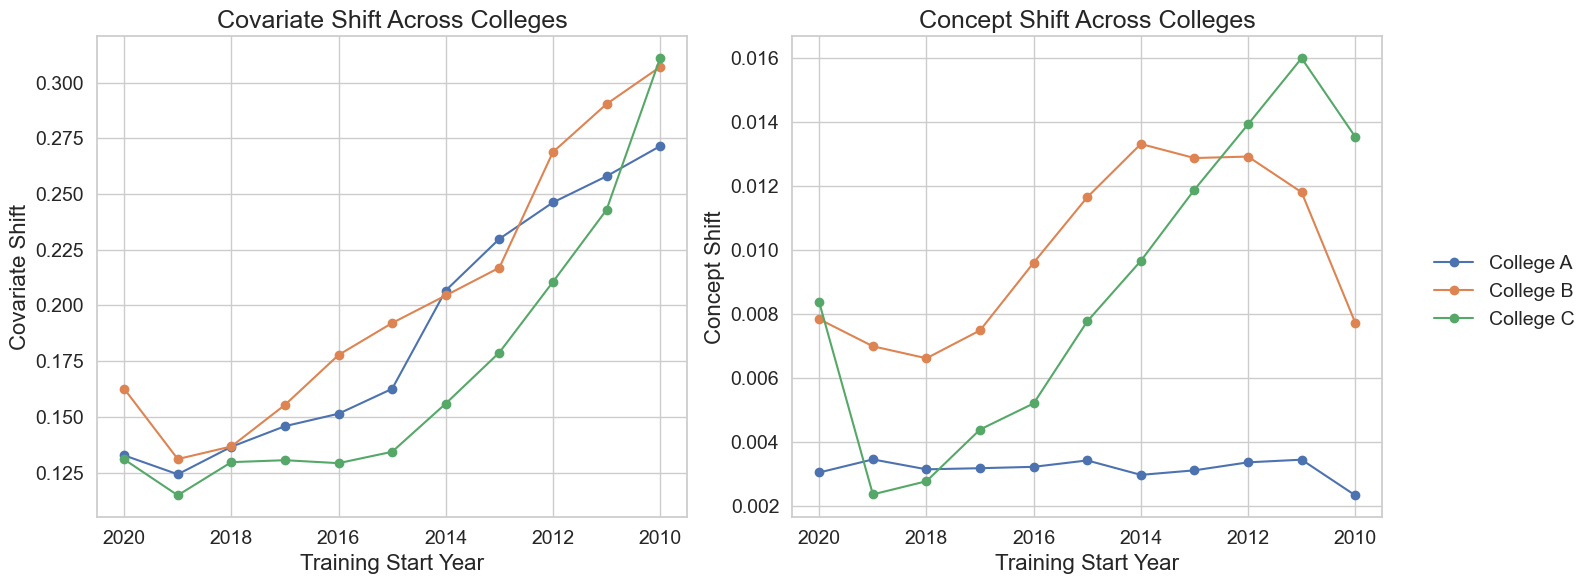

In [ ]:

selected_colleges = ['J._Sargeant_Reynolds', 'Virginia_Peninsula', 'Danville']
deid_map = {
    'J._Sargeant_Reynolds': 'College A',
    'Virginia_Peninsula': 'College B',
    'Danville': 'College C'
}


df_plot = df_all[df_all['college_name'].isin(selected_colleges)].copy()
df_plot['train_start'] = df_plot['train_years'].apply(lambda x: int(x.split('–')[0]))
df_plot['school'] = df_plot['college_name'].map(deid_map)


df_plot = df_plot.sort_values(by=['school', 'train_start'])


fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharex=True)

for school in df_plot['school'].unique():
    df_school = df_plot[df_plot['school'] == school]
    axes[0].plot(df_school['train_start'], df_school['unified_shift_score'], marker='o', label=school)

axes[0].set_xlabel("Training Start Year", fontsize=16)
axes[0].set_ylabel("Covariate Shift", fontsize=16)
axes[0].set_title("Covariate Shift Across Colleges", fontsize=18)
axes[0].tick_params(axis='x', labelsize=14)
axes[0].tick_params(axis='y', labelsize=14)
axes[0].invert_xaxis()  
axes[0].grid(True)

for school in df_plot['school'].unique():
    df_school = df_plot[df_plot['school'] == school]
    axes[1].plot(df_school['train_start'], df_school['js_divergence'], marker='o', label=school)

axes[1].set_xlabel("Training Start Year", fontsize=16)
axes[1].set_ylabel("Concept Shift", fontsize=16)
axes[1].set_title("Concept Shift Across Colleges", fontsize=18)
axes[1].tick_params(axis='x', labelsize=14)
axes[1].tick_params(axis='y', labelsize=14)
axes[1].grid(True)

handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, fontsize=14, loc='center right', bbox_to_anchor=(1, 0.5), frameon=False)

plt.tight_layout(rect=[0, 0, 0.88, 1])
plt.savefig('shift_comparison_selected_schools.png', bbox_inches='tight', dpi=500)
plt.show()


In [49]:
summary_table = model.summary2().tables[1]
print(summary_table.loc[['js_divergence_resid', 'unified_shift_score']])



                        Coef.  Std.Err.         t         P>|t|    [0.025  \
js_divergence_resid  0.257348  0.099535  2.585496  1.034636e-02  0.061221   
unified_shift_score  0.092504  0.013231  6.991409  2.978801e-11  0.066433   

                       0.975]  
js_divergence_resid  0.453475  
unified_shift_score  0.118574  


In [ ]:
df_all['train_years_num'] = df_all['end_year'] - df_all['start_year'] + 1
model = smf.ols('auc_test_2019 ~   unified_shift_score * js_divergence_resid  + C(college_name)', data=df_all).fit()
print(model.summary())


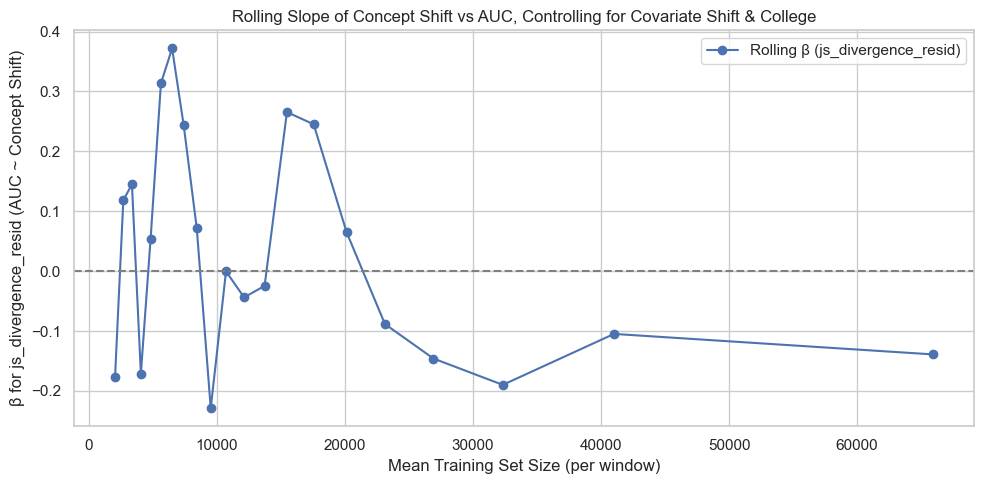

In [ ]:
import statsmodels.formula.api as smf


df = df_all.dropna(subset=['auc_test_2019', 'js_divergence_resid', 'unified_shift_score', 'n_train_x', 'college_name']).copy()
df = df.sort_values('n_train_x')

window_size = 50
step_size = 10

results = []

for start in range(0, len(df) - window_size + 1, step_size):
    end = start + window_size
    sub = df.iloc[start:end].copy()

    if sub['college_name'].nunique() < 2:  
        continue

    try:
        model = smf.ols(
            'auc_test_2019 ~ js_divergence_resid + unified_shift_score + C(college_name)',
            data=sub
        ).fit()
        coef = model.params.get('js_divergence_resid', np.nan)
        pval = model.pvalues.get('js_divergence_resid', np.nan)
    except Exception as e:
        coef = np.nan
        pval = np.nan

    results.append({
        'mean_n_train': sub['n_train_x'].mean(),
        'coef_js': coef,
        'p_js': pval
    })

df_rolling = pd.DataFrame(results)

plt.figure(figsize=(10, 8))
plt.plot(df_rolling['mean_n_train'], df_rolling['coef_js'], marker='o', label='Rolling β (js_divergence_resid)')
plt.axhline(0, linestyle='--', color='gray')
plt.xlabel('Mean Training Set Size (per window)')
plt.ylabel('β for (AUC ~ Concept Shift)')
plt.title('Rolling Slope of Concept Shift vs AUC')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:

df_all['n_train_tertile'] = pd.qcut(df_all['n_train_x'], q=3, labels=['Low', 'Medium', 'High'])
df_all['n_train_equalwidth'] = pd.cut(df_all['n_train_x'], bins=3, labels=['Low', 'Medium', 'High'])


In [ ]:
df_all['n_train_tertile'] = pd.qcut(df_all['n_train_x'], q=3, labels=['Low', 'Medium', 'High'])
tertile_ranges = df_all.groupby('n_train_tertile')['n_train_x'].agg(['min', 'max']).reset_index()

print(tertile_ranges)


  n_train_tertile    min     max
0             Low    368    6350
1          Medium   6441   18217
2            High  18218  368424


In [ ]:

tertile_results = []

for group, sub in df_all.groupby('n_train_tertile'):  
    if len(sub) < 4:
        continue 

    try:
        model = smf.ols(
            formula="auc_test_2019 ~ unified_shift_score * js_divergence_resid + C(college_name)",
            data=sub
        ).fit()

        tertile_results.append({
            'n_train_group': group,
            'n': len(sub),
            'coef_js': model.params.get('js_divergence_resid', float('nan')),
            'p_js': model.pvalues.get('js_divergence_resid', float('nan')),
            'coef_cov': model.params.get('unified_shift_score', float('nan')),              
            'p_cov': model.pvalues.get('unified_shift_score', float('nan')),                 
            'coef_interaction': model.params.get('unified_shift_score:js_divergence_resid', float('nan')),
            'p_interaction': model.pvalues.get('unified_shift_score:js_divergence_resid', float('nan')),
            'r_squared': model.rsquared
        })

    except Exception as e:
        print(f"⚠️ Regression failed for group {group}: {e}")

reg_df = pd.DataFrame(tertile_results)
print(reg_df)


  n_train_group   n   coef_js      p_js  coef_cov     p_cov  coef_interaction  \
0           Low  85  0.291331  0.456721 -0.105884  0.000226         -1.340138   
1        Medium  84 -0.386356  0.261972 -0.020562  0.297863          2.407879   
2          High  84 -0.541205  0.003165 -0.026133  0.007216          1.405059   

   p_interaction  r_squared  
0       0.501165   0.979664  
1       0.075541   0.994737  
2       0.013724   0.997978  


## FAIRNESS

In [ ]:
try:
    import cupy as cp
except ImportError:
    cp = np
    print("Cupy not found; using NumPy (CPU) instead. Performance will be slower.")
-
def estimate_p_y_knn_gpu(X_train, y_train, X_query, k=30, batch_size=256):
    try:
        X_tr = cp.asarray(X_train, dtype=cp.float32)
        y_tr = cp.asarray(y_train, dtype=cp.float32)
        X_q = cp.asarray(X_query, dtype=cp.float32)
    except Exception as e:
        print(f"[GPU init error] {e}, falling back to CPU")
        return estimate_p_y_knn_cpu(X_train, y_train, X_query, k, batch_size)

    n_query = X_q.shape[0]
    probs = np.empty(n_query, dtype=float)
    for i in range(0, n_query, batch_size):
        j = min(i + batch_size, n_query)
        chunk = X_q[i:j]
        try:
            diff = X_tr[:, None, :] - chunk[None, :, :]
            d2 = cp.einsum('tbf,tbf->tb', diff, diff)
            idx = cp.argpartition(d2, k, axis=0)[:k, :]
            neigh = cp.take(y_tr, idx, axis=0)
            p_chunk = cp.mean(neigh, axis=0)
            probs[i:j] = cp.asnumpy(p_chunk)
        except Exception as e:
            print(f"[GPU batch error @ {i}:{j}] {e}, falling back to CPU")
            return estimate_p_y_knn_cpu(X_train, y_train, X_query, k, batch_size)
    return probs

def estimate_p_y_knn_cpu(X_train, y_train, X_query, k=30, batch_size=256):
    n_query = X_query.shape[0]
    probs = np.empty(n_query, dtype=float)
    for i in range(0, n_query, batch_size):
        j = min(i + batch_size, n_query)
        chunk = X_query[i:j]
        d2 = np.sum((X_train[:, None, :] - chunk[None, :, :])**2, axis=2)
        idx = np.argpartition(d2, k, axis=0)[:k]
        probs[i:j] = np.mean(y_train[idx], axis=0)
    return probs

def js_divergence_kde(p, q, eps=1e-10, num_points=1000):
    low, high = min(p.min(), q.min()) - eps, max(p.max(), q.max()) + eps
    grid = np.linspace(low, high, num_points)
    kde_p = gaussian_kde(p)
    kde_q = gaussian_kde(q)
    p_vals = kde_p(grid) + eps
    q_vals = kde_q(grid) + eps
    p_vals /= p_vals.sum()
    q_vals /= q_vals.sum()
    m_vals = 0.5 * (p_vals + q_vals)
    kl_pm = entropy(p_vals, m_vals)
    kl_qm = entropy(q_vals, m_vals)
    return 0.5 * (kl_pm + kl_qm)

def cramers_v(conf_matrix):
    chi2 = chi2_contingency(conf_matrix)[0]
    n = conf_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = conf_matrix.shape
    return np.sqrt(phi2 / min(k - 1, r - 1))

def run_temporal_shift_analysis_intersectional(
    df,
    feature_cols,
    target_col,
    demo_cols,
    test_year,
    group_col='college_name',
    year_col='year',
    min_train=100,
    min_test=50,
    k=30,
    pca_var=0.95
):
    results = []

    binary_vars = [col for col in feature_cols if df[col].dropna().nunique() == 2]
    cont_vars = list(set(feature_cols) - set(binary_vars))
    subgroup_df = df[demo_cols].drop_duplicates()
    min_year = df[year_col].min()
    train_start_years = list(range(min_year, test_year))

    for _, subgroup in subgroup_df.iterrows():
        mask = np.logical_and.reduce([df[col] == subgroup[col] for col in demo_cols])
        df_sub = df[mask]

        for college in df_sub[group_col].dropna().unique():
            sub = df_sub[df_sub[group_col] == college]
            df_test = sub[sub[year_col] == test_year]
            if len(df_test) < min_test:
                continue

            for start_year in train_start_years:
                train_years = list(range(start_year, test_year))
                df_train = sub[sub[year_col].isin(train_years)]
                if len(df_train) < min_train:
                    continue

            
                X_train = df_train[feature_cols].fillna(0).values
                y_train = df_train[target_col].values
                X_test = df_test[feature_cols].fillna(0).values
                y_test = df_test[target_col].values

                scaler = StandardScaler().fit(X_train)
                Xtr = scaler.transform(X_train)
                Xte = scaler.transform(X_test)

                pca = PCA(n_components=pca_var)
                Xtr = pca.fit_transform(Xtr)
                Xte = pca.transform(Xte)
                eff_k = min(k, len(Xtr) // 2)

                try:
                    p_train = estimate_p_y_knn_gpu(Xtr, y_train, Xtr, k=eff_k)
                    p_test = estimate_p_y_knn_gpu(Xte, y_test, Xte, k=eff_k)
                except:
                    p_train = estimate_p_y_knn_cpu(Xtr, y_train, Xtr, k=eff_k)
                    p_test = estimate_p_y_knn_cpu(Xte, y_test, Xte, k=eff_k)

                js = js_divergence_kde(p_train, p_test)

                train_cont = df_train[cont_vars].dropna()
                test_cont = df_test[cont_vars].dropna()
                all_cont = pd.concat([train_cont, test_cont])
                scaler_cont = StandardScaler().fit(all_cont)
                train_scaled = scaler_cont.transform(train_cont)
                test_scaled = scaler_cont.transform(test_cont)

                pca_cov = PCA(n_components=min(5, all_cont.shape[1]))
                Xtr_cov = pca_cov.fit_transform(train_scaled)
                Xte_cov = pca_cov.transform(test_scaled)

                ks_vals = [ks_2samp(Xtr_cov[:, i], Xte_cov[:, i]).statistic for i in range(pca_cov.n_components_)]
                ks_norm = np.array(ks_vals) / np.max(ks_vals) if ks_vals else [np.nan]
                pca_shift_score = np.mean(ks_norm)

                binary_shift_scores = []
                for feat in binary_vars:
                    try:
                        delta = abs(df_train[feat].mean() - df_test[feat].mean())
                        ct = pd.crosstab(sub[sub[year_col].isin(train_years + [test_year])][year_col],
                                         sub[sub[year_col].isin(train_years + [test_year])][feat])
                        if ct.shape[0] >= 2 and ct.shape[1] == 2:
                            c_v = cramers_v(ct)
                            binary_shift_scores.append(((delta / df[feat].std()) + c_v) / 2)
                    except:
                        continue
                binary_shift_score = np.mean(binary_shift_scores) if binary_shift_scores else np.nan

                unified_shift_score = np.nanmean([pca_shift_score, binary_shift_score])

                clf = LogisticRegression(max_iter=1000, solver='lbfgs')
                clf.fit(df_train[feature_cols].fillna(0), y_train)
                y_pred = clf.predict_proba(df_test[feature_cols].fillna(0))[:, 1]
                auc_all = roc_auc_score(y_test, y_pred)

                mask_test = np.logical_and.reduce([df_test[col] == subgroup[col] for col in demo_cols])
                y_test_sub = y_test[mask_test]
                y_pred_sub = y_pred[mask_test]
                auc_sub = roc_auc_score(y_test_sub, y_pred_sub) if len(np.unique(y_test_sub)) >= 2 and len(y_test_sub) >= 20 else np.nan

                results.append({
                    'college_name': college,
                    'start_year': start_year,
                    'end_year': test_year,
                    'js_divergence': js,
                    'pca_shift': pca_shift_score,
                    'binary_shift': binary_shift_score,
                    'unified_shift_score': unified_shift_score,
                    'auc_all': auc_all,
                    'auc_subgroup': auc_sub,
                    **{col: subgroup[col] for col in demo_cols}
                })

    return pd.DataFrame(results)


In [ ]:
fairness = run_temporal_shift_analysis_intersectional(
    df=Anonymized_college,
    feature_cols=cols,
    target_col='retention',
    demo_cols=['urm_status', 'sex_Female'],
    test_year=2021
)


In [240]:
fairness['end_year'] = 2020

In [ ]:
def evaluate_logistic_fairness_expanding_by_college(
    df,
    feature_cols,
    target_col,
    demo_cols,
    test_year,
    college_col='college_name',
    year_col='year',
    min_train=100,
    min_test=50,
    min_year=None
):
    results = []

    if min_year is None:
        min_year = df[year_col].min()

    train_start_years = list(range(min_year, test_year))

    for college in df[college_col].dropna().unique():
        df_college = df[df[college_col] == college]

        df_test = df_college[df_college[year_col] == test_year]
        if len(df_test) < min_test:
            continue

        for start_year in train_start_years:
            train_years = list(range(start_year, test_year))
            df_train = df_college[df_college[year_col].isin(train_years)]

            if len(df_train) < min_train:
                continue

            X_train = df_train[feature_cols].fillna(0)
            y_train = df_train[target_col]
            X_test = df_test[feature_cols].fillna(0)
            y_test = df_test[target_col]

            model = LogisticRegression(max_iter=1000, solver='lbfgs')
            model.fit(X_train, y_train)

            y_pred_all = model.predict_proba(X_test)[:, 1]
            auc_all = roc_auc_score(y_test, y_pred_all)

            results.append({
                'college': college,
                'train_start_year': start_year,
                'train_end_year': test_year - 1,
                'test_year': test_year,
                'group': 'ALL',
                'auc': auc_all,
                'n_test': len(y_test)
            })

            unique_groups = df_test[demo_cols].drop_duplicates()

            for _, group_vals in unique_groups.iterrows():
                mask = np.logical_and.reduce([
                    df_test[col] == group_vals[col] for col in demo_cols
                ])
                sub_df = df_test[mask]

                if len(sub_df) < 20 or sub_df[target_col].nunique() < 2:
                    continue

                y_true = sub_df[target_col]
                y_pred = model.predict_proba(sub_df[feature_cols].fillna(0))[:, 1]
                auc = roc_auc_score(y_true, y_pred)

                group_result = {
                    'college': college,
                    'train_start_year': start_year,
                    'train_end_year': test_year - 1,
                    'test_year': test_year,
                    'group': '_'.join([f"{col}={group_vals[col]}" for col in demo_cols]),
                    'auc': auc,
                    'n_test': len(sub_df)
                }

                for col in demo_cols:
                    group_result[col] = group_vals[col]

                results.append(group_result)

    return pd.DataFrame(results)


In [ ]:
fairness_auc_by_college = evaluate_logistic_fairness_expanding_by_college(
    df=Anonymized_college,
    feature_cols=cols,
    target_col='retention',
    demo_cols=['urm_status', 'sex_Female'],
    test_year=2021
)


In [ ]:

fairness_subgroup = fairness.copy()

fairness_subgroup['train_start_year'] = fairness_subgroup['start_year']
fairness_subgroup['train_end_year'] = fairness_subgroup['end_year']
fairness_subgroup['test_year'] = 2021 


auc_all_df = fairness_auc_by_college[
    fairness_auc_by_college['group'] == 'ALL'
][['college', 'train_start_year', 'train_end_year', 'test_year', 'auc']].rename(
    columns={
        'college': 'college_name',
        'auc': 'auc_all'
    }
)

auc_sub_df = fairness_auc_by_college[
    fairness_auc_by_college['group'] != 'ALL'
][['college', 'train_start_year', 'train_end_year', 'test_year', 'auc', 'urm_status', 'sex_Female']].rename(
    columns={
        'college': 'college_name',
        'auc': 'auc_subgroup'
    }
)

merged = pd.merge(
    fairness_subgroup.drop(columns=['auc_all', 'auc_subgroup'], errors='ignore'),
    auc_all_df,
    on=['college_name', 'train_start_year', 'train_end_year', 'test_year'],
    how='left'
)

merged = pd.merge(
    merged,
    auc_sub_df,
    on=['college_name', 'train_start_year', 'train_end_year', 'test_year', 'urm_status', 'sex_Female'],
    how='left'
)

final_fairness = merged[[
    'college_name', 'train_start_year', 'train_end_year', 'test_year',
    'js_divergence', 'pca_shift', 'binary_shift', 'unified_shift_score',
    'auc_all', 'auc_subgroup', 'urm_status', 'sex_Female'
]]


In [ ]:

df = final_fairness.copy()
df = df.dropna(subset=['js_divergence', 'unified_shift_score'])
df['group_id'] = df['urm_status'].astype(str) + '_' + df['sex_Female'].astype(str)
residual_dfs = []
for (college, group), sub_df in df.groupby(['college_name', 'group_id']):
    if len(sub_df) < 3:
        continue 

    X = sm.add_constant(sub_df[['unified_shift_score']])
    y = sub_df['js_divergence']
    model = sm.OLS(y, X).fit()

    sub_df = sub_df.copy()
    sub_df['js_divergence_resid'] = model.resid
    residual_dfs.append(sub_df)
df_residualized = pd.concat(residual_dfs, ignore_index=True)


In [ ]:
df = df_residualized.copy()
df['group'] = df['urm_status'].astype(str) + "_" + df['sex_Female'].astype(str)

df['group_label'] = df['group'].map({
    '0_0': 'Non-URM_Male',
    '0_1': 'Non-URM_Female',
    '1_0': 'URM_Male',
    '1_1': 'URM_Female'
})
df_shift_by_group = (
    df.groupby(['college_name', 'train_start_year', 'group_label'])
      .agg(mean_js_resid=('js_divergence_resid', 'mean'))
      .reset_index()
)


### Concept shift

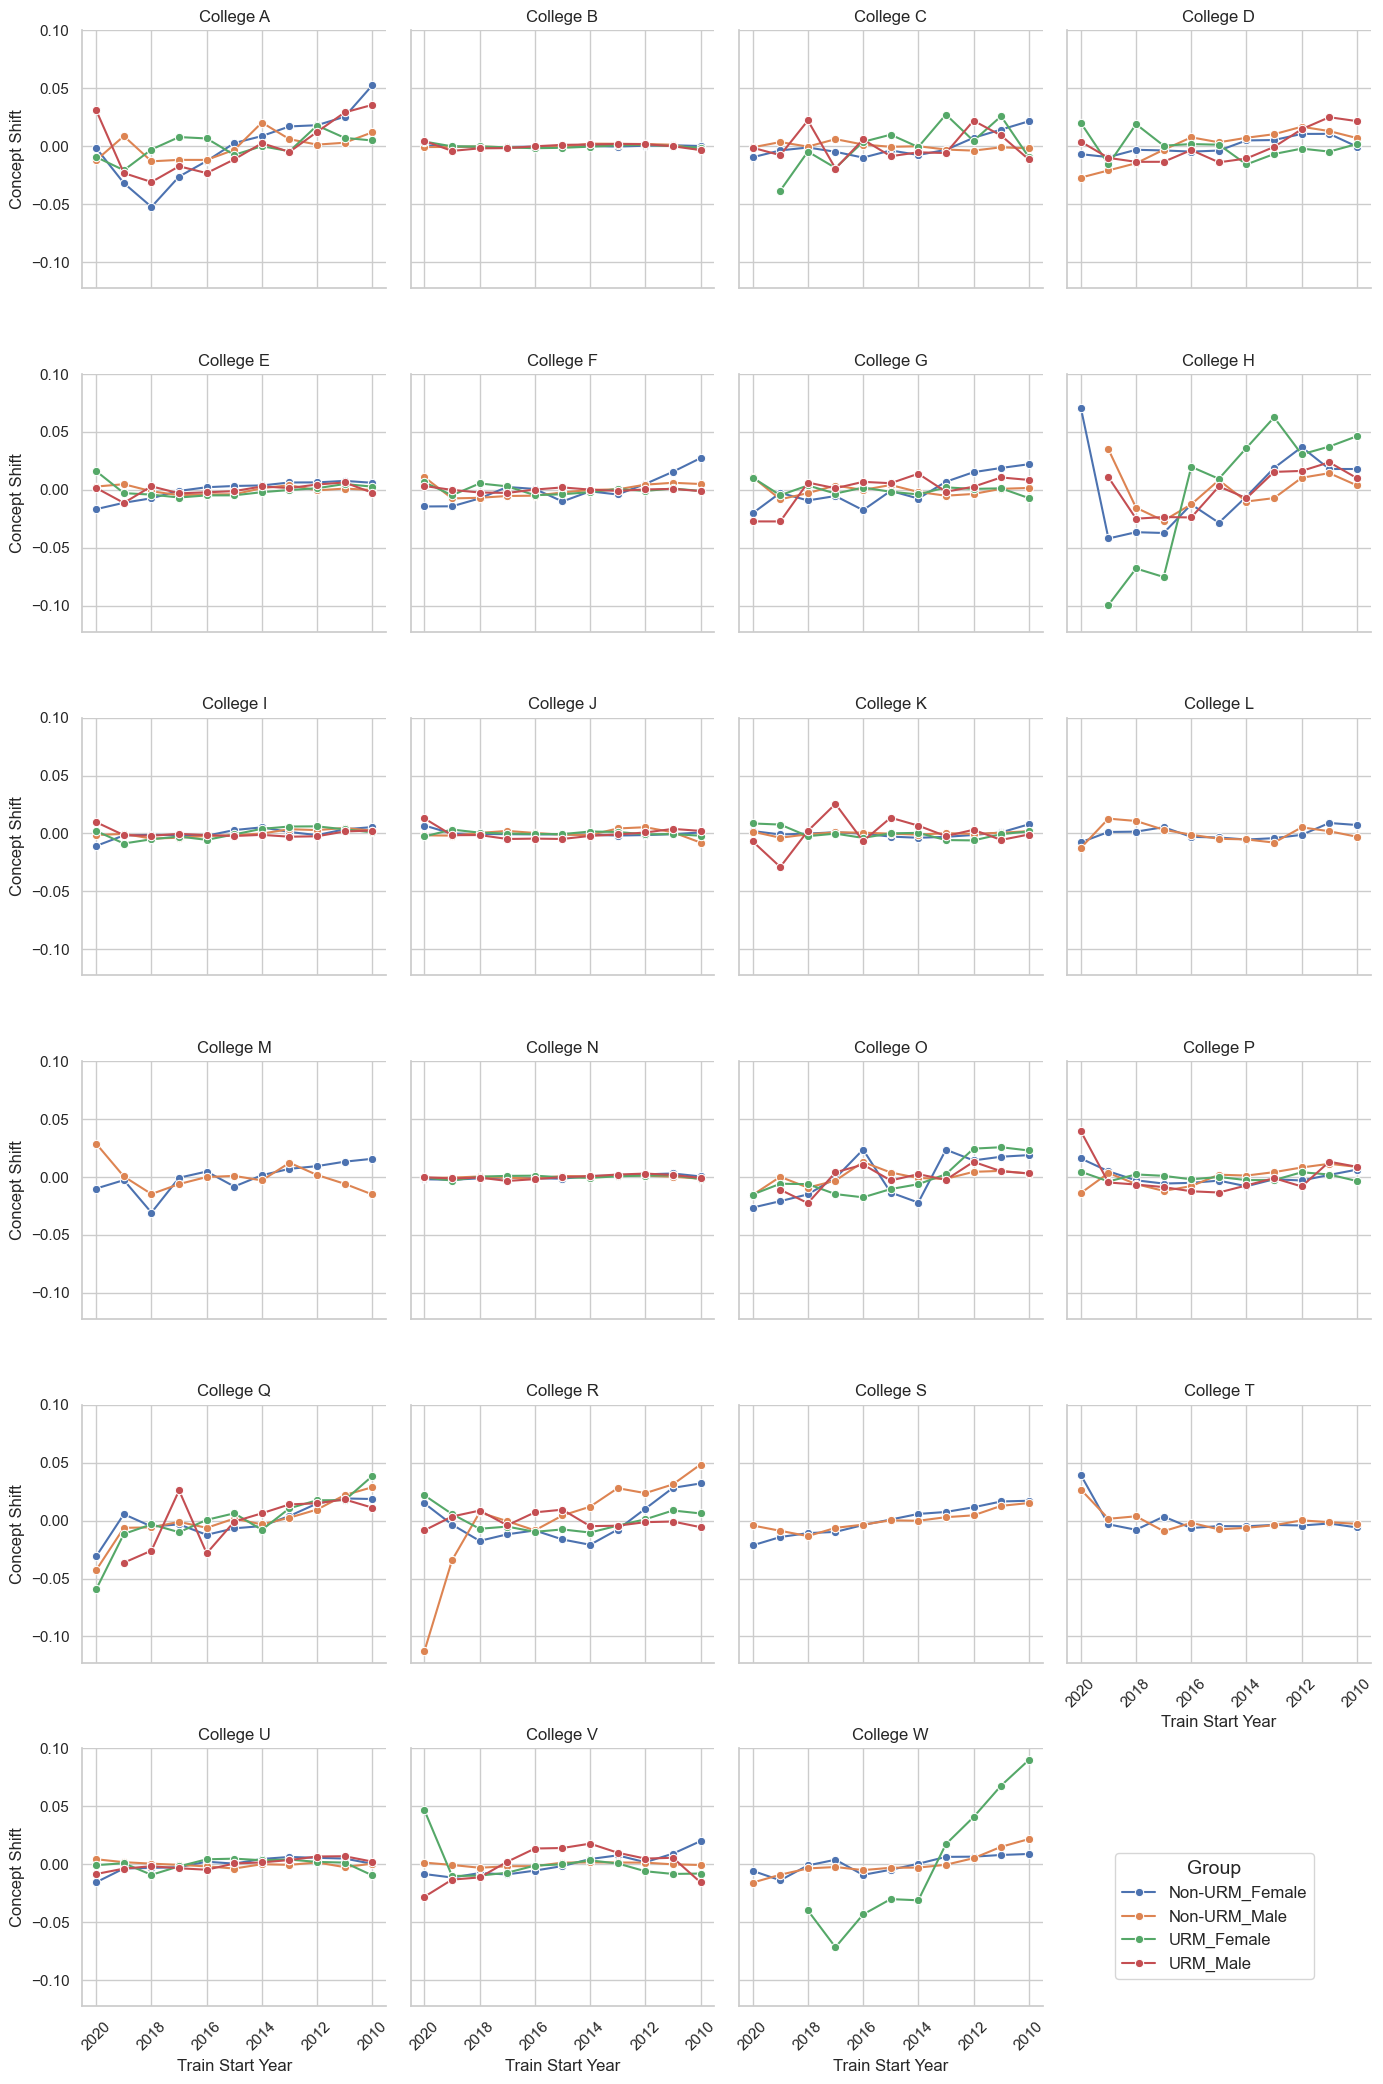

In [ ]:
df = df_residualized.copy()
df['group'] = df['urm_status'].astype(str) + "_" + df['sex_Female'].astype(str)
df['group_label'] = df['group'].map({
    '0_0': 'Non-URM_Male',
    '0_1': 'Non-URM_Female',
    '1_0': 'URM_Male',
    '1_1': 'URM_Female'
})

manual_mapping = {
    'Patrick_Henry': 'College A',
    'Tidewater': 'College B',
    'New_River': 'College C'
}
all_colleges = df['college_name'].unique()
remaining = [c for c in all_colleges if c not in manual_mapping]
remaining_mapping = {
    orig: f"College {chr(68 + i)}" for i, orig in enumerate(sorted(remaining))
}
anon_map = {**manual_mapping, **remaining_mapping}
df['college_anon'] = df['college_name'].map(anon_map)

df_shift_by_group = (
    df.groupby(['college_anon', 'train_start_year', 'group_label'])
      .agg(mean_js_resid=('js_divergence_resid', 'mean'))
      .reset_index()
)

sns.set(style="whitegrid")
g = sns.FacetGrid(
    df_shift_by_group,
    col='college_anon',
    col_wrap=4,
    height=3.5,
    sharey=True
)

g.map_dataframe(
    sns.lineplot,
    x='train_start_year',
    y='mean_js_resid',
    hue='group_label',
    marker='o'
)

for ax in g.axes.flatten():
    ax.invert_xaxis()
    for label in ax.get_xticklabels():
        label.set_rotation(45)

handles, labels = g.axes[0].get_legend_handles_labels()


g.fig.legend(
    handles,
    labels,
    title='Group',
    loc='lower right',
    bbox_to_anchor=(0.95, 0.05), 
    fontsize=12,
    title_fontsize=14
)
g.set_axis_labels("Train Start Year", "Concept Shift")
g.set_titles("{col_name}")
g.fig.subplots_adjust(top=0.9)

plt.tight_layout()
plt.savefig('intersectional_concept_shift.png', bbox_inches='tight', dpi=500)
plt.show()


### AUC

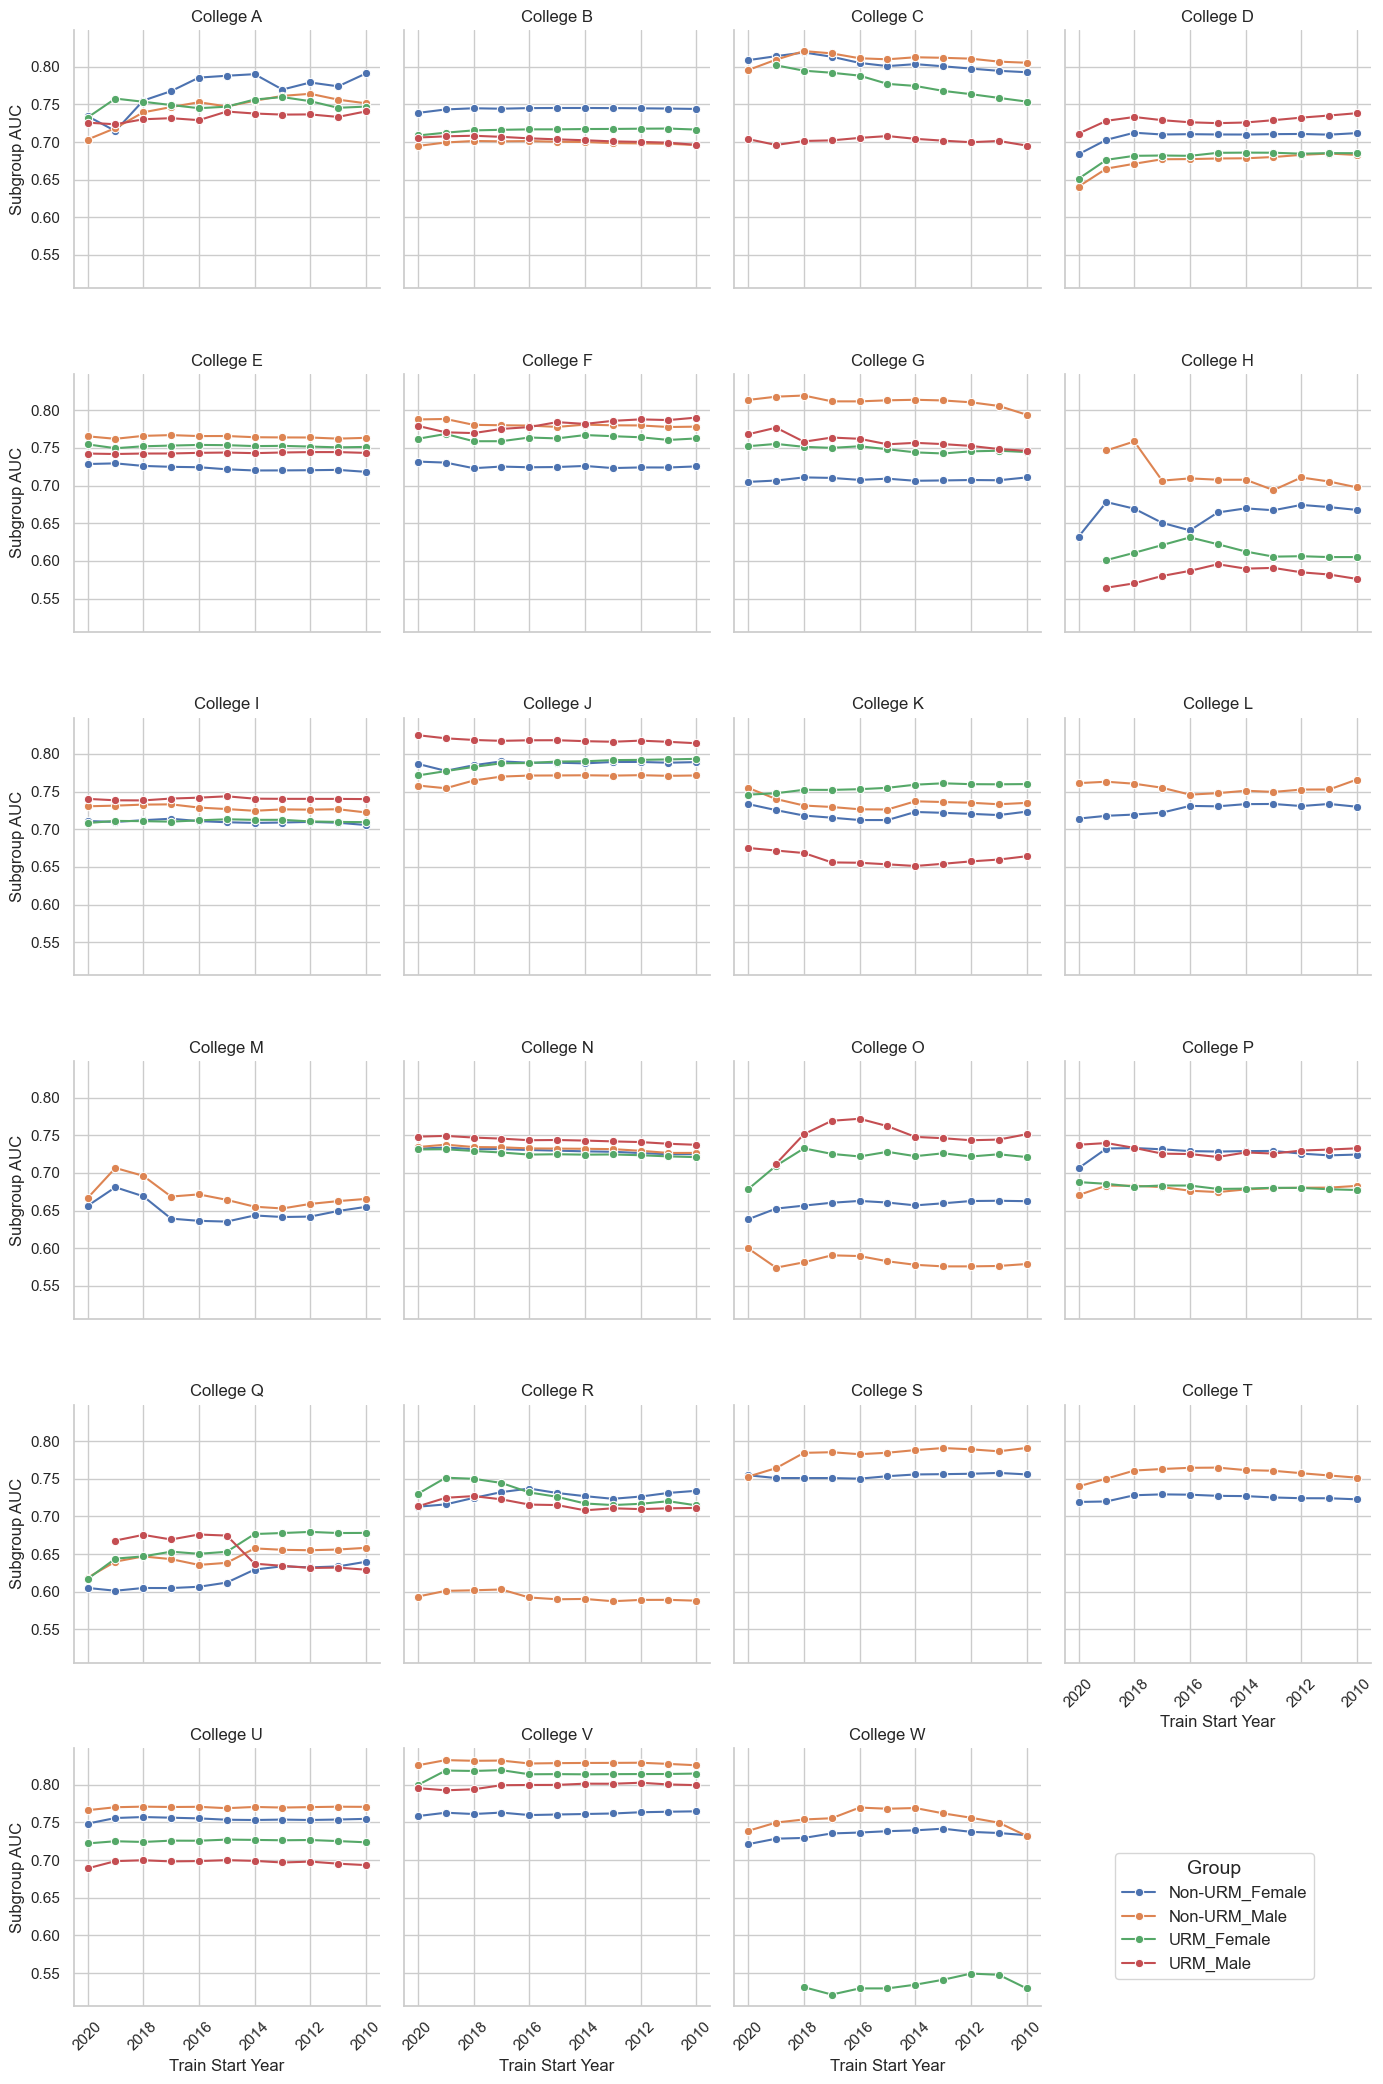

In [ ]:
df = df_residualized.copy()
df['group'] = df['urm_status'].astype(str) + "_" + df['sex_Female'].astype(str)
df['group_label'] = df['group'].map({
    '0_0': 'Non-URM_Male',
    '0_1': 'Non-URM_Female',
    '1_0': 'URM_Male',
    '1_1': 'URM_Female'
})

manual_mapping = {
    'C1': 'College A',
    'C2': 'College B',
    'C3': 'College C'
}
all_colleges = df['college_name'].unique()
remaining = [c for c in all_colleges if c not in manual_mapping]
remaining_mapping = {
    orig: f"College {chr(68 + i)}" for i, orig in enumerate(sorted(remaining))
}
anon_map = {**manual_mapping, **remaining_mapping}
df['college_anon'] = df['college_name'].map(anon_map)

df_shift_by_group = (
    df.groupby(['college_anon', 'train_start_year', 'group_label'])
      .agg(mean_auc=('auc_subgroup', 'mean'))
      .reset_index()
)

sns.set(style="whitegrid")
g = sns.FacetGrid(
    df_shift_by_group,
    col='college_anon',
    col_wrap=4,
    height=3.5,
    sharey=True
)

g.map_dataframe(
    sns.lineplot,
    x='train_start_year',
    y='mean_auc',
    hue='group_label',
    marker='o'
)

for ax in g.axes.flatten():
    ax.invert_xaxis()
    for label in ax.get_xticklabels():
        label.set_rotation(45)
handles, labels = g.axes[0].get_legend_handles_labels()


g.fig.legend(
    handles,
    labels,
    title='Group',
    loc='lower right',
    bbox_to_anchor=(0.95, 0.05), 
    fontsize=12,
    title_fontsize=14
)
g.set_axis_labels("Train Start Year", "Subgroup AUC")
g.set_titles("{col_name}")
g.fig.subplots_adjust(top=0.9)

plt.tight_layout()
plt.savefig('intersectional_auc.png', bbox_inches='tight', dpi=500)
plt.show()


In [298]:
df_groupgap = (
    df_residualized
    .groupby(['college_name', 'train_start_year'])
    .agg(
        js_gap=('js_divergence_resid', lambda x: x.max() - x.min()),
        cov_gap=('unified_shift_score', lambda x: x.max() - x.min()),
        auc_gap=('auc_subgroup', lambda x: x.max() - x.min()),
        cov_shift=('unified_shift_score', 'mean')
    )
    .reset_index()
)


In [ ]:
model_gap = smf.ols(
    'auc_gap ~ js_gap * cov_gap + C(college_name)',
    data=df_groupgap
).fit()
print(model_gap.summary())


In [ ]:

results = []

for college in final_fairness['college_name'].unique():
    college_df = final_fairness[final_fairness['college_name'] == college]

    for (urm, sex), group_df in college_df.groupby(['urm_status', 'sex_Female']):
        df = group_df.dropna(subset=['auc_subgroup', 'js_divergence', 'unified_shift_score'])

        if len(df) < 6:
            continue

        model = ols('auc_subgroup ~ js_divergence + unified_shift_score', data=df).fit()

        results.append({
            'college': college,
            'urm_status': urm,
            'sex_Female': sex,
            'n_obs': len(df),
            'coef_js': model.params.get('js_divergence', np.nan),
            'p_js': model.pvalues.get('js_divergence', np.nan),
            'coef_shift': model.params.get('unified_shift_score', np.nan),
            'p_shift': model.pvalues.get('unified_shift_score', np.nan),
            'r_squared': model.rsquared
        })

regression_results = pd.DataFrame(results)
regression_results 